<a href="https://colab.research.google.com/github/ravish31/pyspark_mllib/blob/main/Group05_IrisDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
!pip install pyspark

In [98]:
import pyspark as sp

sc = sp.SparkContext.getOrCreate()
print(sc)
print(sc.version)

<SparkContext master=local[*] appName=pyspark-shell>
3.5.0


In [142]:
import numpy as np
import zipfile
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import urllib.request
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import IndexToString
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [100]:
rnd_seed=123
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

In [101]:
urllib.request.urlretrieve("https://archive.ics.uci.edu/static/public/53/iris.zip", "iris.zip")
with zipfile.ZipFile('./iris.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [102]:
#Create my_spark
spark = SparkSession.builder.getOrCreate()

#print my_spark
print(spark)

In [103]:
# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("sepalLength", FloatType(), nullable=True),
    StructField("sepalWidth", FloatType(), nullable=True),
    StructField("petalLength", FloatType(), nullable=True),
    StructField("petalWidth", FloatType(), nullable=True),
    StructField("Class", StringType(), nullable=True)]
)
iris_df = spark.read.csv(path='./iris.data', schema=schema).cache()

In [104]:
iris_df.show(5)

+-----------+----------+-----------+----------+-----------+
|sepalLength|sepalWidth|petalLength|petalWidth|      Class|
+-----------+----------+-----------+----------+-----------+
|        5.1|       3.5|        1.4|       0.2|Iris-setosa|
|        4.9|       3.0|        1.4|       0.2|Iris-setosa|
|        4.7|       3.2|        1.3|       0.2|Iris-setosa|
|        4.6|       3.1|        1.5|       0.2|Iris-setosa|
|        5.0|       3.6|        1.4|       0.2|Iris-setosa|
+-----------+----------+-----------+----------+-----------+
only showing top 5 rows



In [105]:
iris_df.columns

['sepalLength', 'sepalWidth', 'petalLength', 'petalWidth', 'Class']

<Axes: xlabel='sepalLength'>

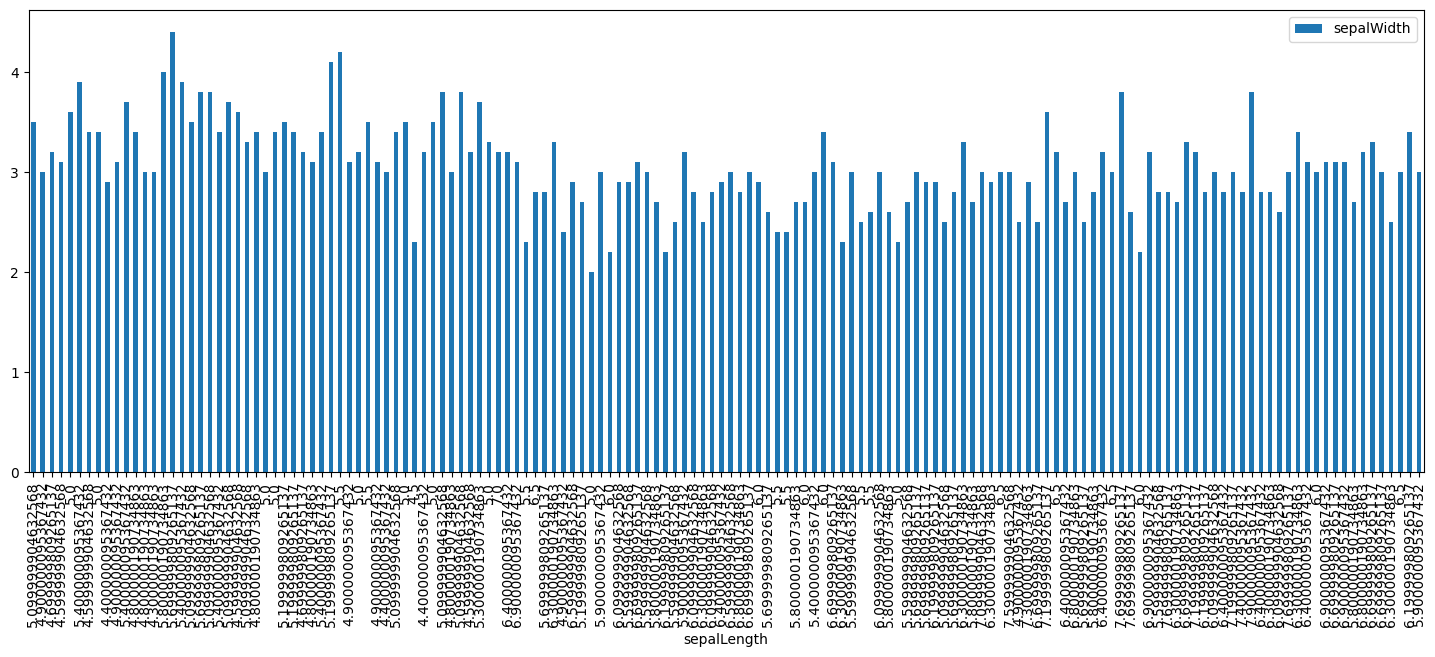

In [106]:
iris_df.toPandas().plot.bar(x='sepalLength',y='sepalWidth',figsize=(18, 6))

<Axes: xlabel='petalLength'>

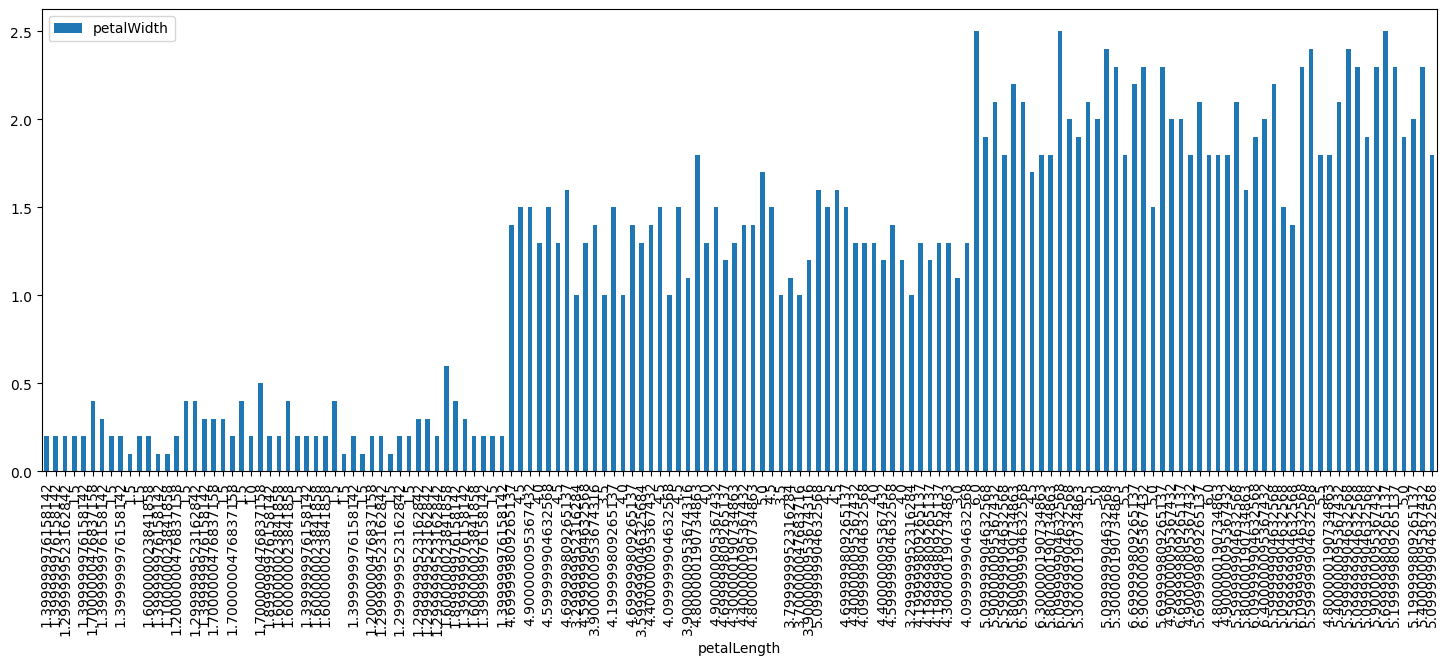

In [107]:
iris_df.toPandas().plot.bar(x='petalLength',y='petalWidth',figsize=(18, 6))

In [109]:
iris_df.select('Class').distinct().show()

+---------------+
|          Class|
+---------------+
| Iris-virginica|
|    Iris-setosa|
|Iris-versicolor|
+---------------+



In [110]:
iris_df.describe().show()


+-------+------------------+-------------------+------------------+------------------+--------------+
|summary|       sepalLength|         sepalWidth|       petalLength|        petalWidth|         Class|
+-------+------------------+-------------------+------------------+------------------+--------------+
|  count|               150|                150|               150|               150|           150|
|   mean| 5.843333326975505| 3.0540000025431313|3.7586666552225747| 1.198666658103466|          NULL|
| stddev|0.8280661128539085|0.43359431104332985|1.7644204144315179|0.7631607319020202|          NULL|
|    min|               4.3|                2.0|               1.0|               0.1|   Iris-setosa|
|    max|               7.9|                4.4|               6.9|               2.5|Iris-virginica|
+-------+------------------+-------------------+------------------+------------------+--------------+



In [116]:
#shape of dataframe
print("shape : ",iris_df.count(),',',len(iris_df.columns))

shape :  150 , 5


In [112]:
feature_cols = iris_df.columns[:-1]
vect_assembler = VectorAssembler(inputCols = feature_cols, outputCol="features")
#Utilize Assembler created above in order to add the feature column
iris_df_features = vect_assembler.transform(iris_df)

In [117]:
iris_df_final=iris_df_features.select("features","Class")

In [118]:
iris_df_final.show()

+--------------------+-----------+
|            features|      Class|
+--------------------+-----------+
|[5.09999990463256...|Iris-setosa|
|[4.90000009536743...|Iris-setosa|
|[4.69999980926513...|Iris-setosa|
|[4.59999990463256...|Iris-setosa|
|[5.0,3.5999999046...|Iris-setosa|
|[5.40000009536743...|Iris-setosa|
|[4.59999990463256...|Iris-setosa|
|[5.0,3.4000000953...|Iris-setosa|
|[4.40000009536743...|Iris-setosa|
|[4.90000009536743...|Iris-setosa|
|[5.40000009536743...|Iris-setosa|
|[4.80000019073486...|Iris-setosa|
|[4.80000019073486...|Iris-setosa|
|[4.30000019073486...|Iris-setosa|
|[5.80000019073486...|Iris-setosa|
|[5.69999980926513...|Iris-setosa|
|[5.40000009536743...|Iris-setosa|
|[5.09999990463256...|Iris-setosa|
|[5.69999980926513...|Iris-setosa|
|[5.09999990463256...|Iris-setosa|
+--------------------+-----------+
only showing top 20 rows



In [119]:
indexer = StringIndexer(inputCol="Class", outputCol="Class_label")
indexerModel = indexer.fit(iris_df_final)
indexed_df = indexerModel.transform(iris_df_final)
indexed_df=indexed_df.drop("Class")

In [120]:
indexerModel.labels

['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

In [121]:
index_to_string = IndexToString(inputCol="Class_label", outputCol="Pred_Category",
                                labels=indexerModel.labels)

In [122]:
index_to_string.transform(indexed_df).show()

+--------------------+-----------+-------------+
|            features|Class_label|Pred_Category|
+--------------------+-----------+-------------+
|[5.09999990463256...|        0.0|  Iris-setosa|
|[4.90000009536743...|        0.0|  Iris-setosa|
|[4.69999980926513...|        0.0|  Iris-setosa|
|[4.59999990463256...|        0.0|  Iris-setosa|
|[5.0,3.5999999046...|        0.0|  Iris-setosa|
|[5.40000009536743...|        0.0|  Iris-setosa|
|[4.59999990463256...|        0.0|  Iris-setosa|
|[5.0,3.4000000953...|        0.0|  Iris-setosa|
|[4.40000009536743...|        0.0|  Iris-setosa|
|[4.90000009536743...|        0.0|  Iris-setosa|
|[5.40000009536743...|        0.0|  Iris-setosa|
|[4.80000019073486...|        0.0|  Iris-setosa|
|[4.80000019073486...|        0.0|  Iris-setosa|
|[4.30000019073486...|        0.0|  Iris-setosa|
|[5.80000019073486...|        0.0|  Iris-setosa|
|[5.69999980926513...|        0.0|  Iris-setosa|
|[5.40000009536743...|        0.0|  Iris-setosa|
|[5.09999990463256..

In [125]:
train_dataset, test_dataset = indexed_df.randomSplit([0.7, 0.3])

In [126]:
train_dataset.describe().show()

+-------+------------------+
|summary|       Class_label|
+-------+------------------+
|  count|               115|
|   mean|1.0869565217391304|
| stddev|0.8009338561658558|
|    min|               0.0|
|    max|               2.0|
+-------+------------------+



In [127]:
test_dataset.describe().show()

+-------+------------------+
|summary|       Class_label|
+-------+------------------+
|  count|                35|
|   mean|0.7142857142857143|
| stddev|0.8250286473253902|
|    min|               0.0|
|    max|               2.0|
+-------+------------------+



In [147]:
#Import Logistic Regression class
from pyspark.ml.classification import LogisticRegression
LogReg = LogisticRegression(featuresCol="features", labelCol="Class_label")
#Train the model on the training using fit() method.
lr_model = LogReg.fit(train_dataset)
#Predict the Class using the evulate method
lr_pred = lr_model.transform(test_dataset)
lr_pred.show()
evaluator = MulticlassClassificationEvaluator()
evaluator.setLabelCol("Class_label")
evaluator.setPredictionCol("prediction")
print('LogisticRegression Accuracy :',evaluator.evaluate(lr_pred, {evaluator.metricName: "accuracy"}))

+--------------------+-----------+--------------------+--------------------+----------+
|            features|Class_label|       rawPrediction|         probability|prediction|
+--------------------+-----------+--------------------+--------------------+----------+
|[4.40000009536743...|        0.0|[37.8734097396438...|[0.99999999999959...|       0.0|
|[4.5,2.2999999523...|        0.0|[16.6119442868875...|[0.58823641971681...|       0.0|
|[4.59999990463256...|        0.0|[33.5061175210980...|[0.99999999989293...|       0.0|
|[4.80000019073486...|        0.0|[32.3185098748713...|[0.99999999774546...|       0.0|
|[4.80000019073486...|        0.0|[36.5490608681223...|[0.99999999999936...|       0.0|
|[4.90000009536743...|        0.0|[33.3678937651676...|[0.99999999953073...|       0.0|
|[4.90000009536743...|        0.0|[33.3678937651676...|[0.99999999953073...|       0.0|
|[5.0,2.2999999523...|        1.0|[-7.5421122911539...|[5.71671622983412...|       1.0|
|[5.0,3.2000000476...|        0.

In [148]:
#Import RandomForest Classifier class
from pyspark.ml.classification import RandomForestClassifier
RFC = RandomForestClassifier(featuresCol="features", labelCol="Class_label")
#Train the model on the training using fit() method.
rfc_model = RFC.fit(train_dataset)
#Predict the Class using the evulate method
rfc_pred = rfc_model.transform(test_dataset)
rfc_pred.show()
evaluator = MulticlassClassificationEvaluator()
evaluator.setLabelCol("Class_label")
evaluator.setPredictionCol("prediction")
print('RandomForestClassifier Accuracy :',evaluator.evaluate(rfc_pred, {evaluator.metricName: "accuracy"}))

+--------------------+-----------+--------------------+--------------------+----------+
|            features|Class_label|       rawPrediction|         probability|prediction|
+--------------------+-----------+--------------------+--------------------+----------+
|[4.40000009536743...|        0.0|      [20.0,0.0,0.0]|       [1.0,0.0,0.0]|       0.0|
|[4.5,2.2999999523...|        0.0|      [20.0,0.0,0.0]|       [1.0,0.0,0.0]|       0.0|
|[4.59999990463256...|        0.0|      [20.0,0.0,0.0]|       [1.0,0.0,0.0]|       0.0|
|[4.80000019073486...|        0.0|      [20.0,0.0,0.0]|       [1.0,0.0,0.0]|       0.0|
|[4.80000019073486...|        0.0|      [20.0,0.0,0.0]|       [1.0,0.0,0.0]|       0.0|
|[4.90000009536743...|        0.0|      [20.0,0.0,0.0]|       [1.0,0.0,0.0]|       0.0|
|[4.90000009536743...|        0.0|      [20.0,0.0,0.0]|       [1.0,0.0,0.0]|       0.0|
|[5.0,2.2999999523...|        1.0|[0.0,19.897179788...|[0.0,0.9948589894...|       1.0|
|[5.0,3.2000000476...|        0.

In [149]:
#Import DecisionTreeClassifier class
from pyspark.ml.classification import DecisionTreeClassifier
DTC = DecisionTreeClassifier(featuresCol="features", labelCol="Class_label")
#Train the model on the training using fit() method.
dtc_model = DTC.fit(train_dataset)
#Predict the Class using the evulate method
dtc_pred = dtc_model.transform(test_dataset)
dtc_pred.show()
evaluator = MulticlassClassificationEvaluator()
evaluator.setLabelCol("Class_label")
evaluator.setPredictionCol("prediction")
print('DecisionTreeClassifier Accuracy :',evaluator.evaluate(dtc_pred, {evaluator.metricName: "accuracy"}))

+--------------------+-----------+--------------+-------------+----------+
|            features|Class_label| rawPrediction|  probability|prediction|
+--------------------+-----------+--------------+-------------+----------+
|[4.40000009536743...|        0.0|[32.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|[4.5,2.2999999523...|        0.0|[32.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|[4.59999990463256...|        0.0|[32.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|[4.80000019073486...|        0.0|[32.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|[4.80000019073486...|        0.0|[32.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|[4.90000009536743...|        0.0|[32.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|[4.90000009536743...|        0.0|[32.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|[5.0,2.2999999523...|        1.0|[0.0,38.0,0.0]|[0.0,1.0,0.0]|       1.0|
|[5.0,3.2000000476...|        0.0|[32.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|[5.0,3.4000000953...|        0.0|[32.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|[5.09999990463256...|   